# Machine Learning and Statistics for Physicists

## Homework 7

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

In [3]:
import scipy.stats

### Problem 1

A [Gaussian Process](https://en.wikipedia.org/wiki/Gaussian_process) specifies a probability density over functions $f(x)$, instead of random variables. For practical work, we usually only work with the values of Gaussian Process (GP) functions $f(x_i)$ at $N$ specified values of $x = x_i$. By definition, probability density of the resulting $f(x_i)$ values is a multivariate Gaussian with $N\times N$ covariance matrix:
$$
C_{ij} = K(x_i, x_j) \; ,
$$
and the mean of each $f(x_i)$ is usually taken to be zero.  A popular choice for $K$ is the "squared-exponential covariance":
$$
K(x, x') = \sigma_0^2 \exp\left[ -\frac{1}{2}\left( \frac{x - x'}{\lambda}\right)^2\right] \; ,
$$
which has two hyperparameters, $\sigma_0$ and $\lambda$. This choice is *stationary*, i.e., translation invariant since $K(x + x_0, x' + x_0) = K(x, x')$. Although this choice of $K$ is itself a Gaussian function, non Gaussian functions are also valid, and $K$ is not the "Gaussian" referred to in the GP name.

To sample functions $f(x)$ from a GP at $N$ specified values of $x_i$, you can simply build the $N\times N$ covariance matrix $C$, then generate values of $f(x_i)$ using [standard methods](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.random.multivariate_normal.html). Implement the function below using this approach:

In [12]:
def gpsample(x, sig0, lam, ngen, gen=None):
    """Generate samples f(x) of functions drawn from a Gaussian process.
    
    The Gaussian process has zero mean and uses the squared-exponential covariance:
    
      K(x1,x2) = sig0 ** 2 exp[ -0.5 * ((x1 - x2) / lam) ** 2]
      
    with hyperparameters sig0 and lam.
    
    Parameters
    ----------
    x : array
        1D array of N values of x where each sampled f(x) will be evaluated.
    sig0 : float
        Gaussian process hyperparameter specifying the vertical scale.
    lam : float
        Gaussian process hyperparameter specifying the correlation length in x.
    ngen : int
        Number of functions f(x) to generate with sampling.
    gen : np.random.RandomState, int or None
        Generator or seed to use for reproducible random numbers.
        
    Returns
    -------
    array
        2D array with shape (ngen, N) of ngen sampled functions f(x), each
        evaluated at the N input x coordinates.
    """
    if not isinstance(gen, np.random.RandomState):
        gen = np.random.RandomState(gen)
    # YOUR CODE HERE
    
    N = len(x)
    
    mean_f = np.zeros(N)
    
    C = np.zeros((N,N))
    
    for i in range(0,N):
        for j in range(0,N):
            C[i,j] =  (sig0 ** 2) * np.exp( -0.5 * ((x[i] - x[j]) / lam) ** 2)
        
    F = gen.multivariate_normal(mean_f, C, ngen)
    
    return F


In [13]:
# A correct solution should pass these tests.
x = np.linspace(-1., 1., 64)
gen = np.random.RandomState(seed=123)
fx = gpsample(x, sig0=1.0, lam=1.0, ngen=10000, gen=gen)
assert fx.shape == (10000, 64)
assert np.round(np.mean(fx), 1) == 0.0
assert np.round(np.std(fx), 1) == 1.0
assert np.round(np.cov(fx[:, 0], fx[:, -1])[0, 1], 1) == 0.1
fx = gpsample(x, sig0=1.0, lam=0.5, ngen=10000, gen=gen)
assert np.round(np.mean(fx), 1) == 0.0
assert np.round(np.std(fx), 1) == 1.0
assert np.round(np.cov(fx[:, 0], fx[:, -1])[0, 1], 1) == 0.0
fx = gpsample(x, sig0=2.0, lam=2.0, ngen=10000, gen=gen)
assert np.round(np.mean(fx), 1) == 0.0
assert np.round(np.std(fx), 1) == 2.0
assert np.round(np.cov(fx[:, 0], fx[:, -1])[0, 1], 1) == 2.5

Plot a few functions sampled from a Gaussian process using different values of the hyperparameters and observe their influence:

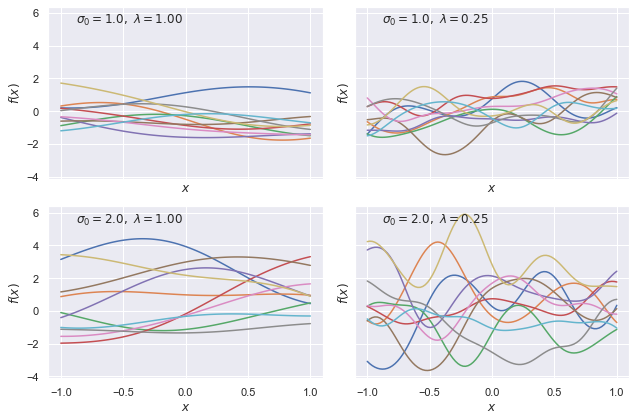

In [14]:
x = np.linspace(-1., 1., 100)
gen = np.random.RandomState(seed=123)
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(9, 6))
for sig0, lam, ax in zip((1.0, 1.0, 2.0, 2.0), (1.0, 0.25, 1.0, 0.25), axes.flatten()):
    fx = gpsample(x, sig0, lam, ngen=10, gen=gen)
    ax.plot(x, fx.T, '-')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$f(x)$')
    ax.text(0.1, 0.9, f'$\\sigma_0={sig0:.1f},\\ \\lambda={lam:.2f}$',
            transform=ax.transAxes, fontsize=12)
plt.tight_layout()

A Gaussian Process is a good prior for learning a function that explains some observed data. A particularly nice feature for scientific applications is that GP learning can use the uncertainties in the observed data and provides a fully Bayesian posterior probability density.

Samples of the Bayesian posterior can be obtained by randomly selecting samples of the prior with probability equal to their likelihood. If we have observed $f_\text{obs}$ at $x_\text{obs}$ with uncertainty $\delta f_\text{obs}$, then the likelihood of a function $f(x)$ is the normal probability density:
$$
{\cal N}\left(x = f_\text{obs} - f(x_\text{obs}) \mid \mu=0, \sigma=\delta f_\text{obs}\right)
$$
With observations at multiple values of $x$, the combined likelihood is the product of factors like this (which can be calculated more accurately using the sum of log likelihoods).

Implement the function below to "learn" a Gaussian Process that explains some observed data using this approach. Use your `gpsample` to sample from the prior and [scipy.stats.norm.logpdf](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html) to evaluate the necessary log-likelihood values. Hint: since you will be randomly selecting some fraction of the prior samples you will need some iteration in order to return exactly `ngen` posterior samples.

In [106]:
def gplearn(iobs, fobs, dfobs, x, sig0, lam, ngen, gen):
    """Sample from the posterior of a Gaussian process given some observed data.
    
    Parameters
    ----------
    iobs : array
        1D array of integers specifying indices i of the x[i] where f(x) has been
        observed.
    fobs : array
        1D array of observed values f(x[i]) for each value i in iobs.
    dfobs : array
        1D array of Gaussian 1-sigma errors on each observation in fobs.
    x : array
        1D array of N values of x where each sampled f(x) will be evaluated.
    sig0 : float
        Gaussian process hyperparameter specifying the vertical scale.
    lam : float
        Gaussian process hyperparameter specifying the correlation length in x.
    ngen : int
        Number of functions f(x) to generate with sampling from the posterior.
    gen : np.random.RandomState, int or None
        Generator or seed to use for reproducible random numbers.
        
    Returns
    -------
    array
        2D array with shape (ngen, N) of ngen sampled functions f(x), each
        evaluated at the N input x coordinates.    
    """
    assert len(iobs) == len(fobs) and len(iobs) == len(dfobs)
    if not isinstance(gen, np.random.RandomState):
        gen = np.random.RandomState(gen)
    # YOUR CODE HERE
    
    Nobs = len(iobs)
    N = len(x)
    
    i = 0
    
    GP = np.zeros((ngen,N))
    
    while i < ngen:
        
        fsamp = gpsample(x, sig0, lam, 1, gen)
        fsamp = np.reshape(fsamp,(N))
        
        loglike = 0.0
        
        for j in range(Nobs):
            
            k = iobs[j]
            df = fobs[j] - fsamp[k]
            sigma = dfobs[j]
            loglike += scipy.stats.norm.logpdf(df, 0.0, sigma)
        
        acceptprob = np.exp(loglike)
        
        if gen.uniform() < acceptprob:
            
            GP[i] = fsamp
            
            i = i + 1
    
    return GP


In [107]:
# A correct solution should pass these tests.
ngen, sig0, lam = 100, 2.0, 0.5
x = np.linspace(-1., 1., 25)
gen = np.random.RandomState(seed=123)
fx = gplearn([5], [0.], [0.1], x, sig0, lam, ngen, gen)
assert fx.shape == (ngen, len(x))
assert np.round(np.mean(fx[:, 5]), 1) == 0.0
assert np.round(np.std(fx[:, 5]), 1) == 0.1
fx = gplearn([20], [1.0], [0.2], x, sig0, lam, ngen, gen)
assert fx.shape == (ngen, len(x))
assert np.round(np.mean(fx[:, 20]), 1) == 1.0
assert np.round(np.std(fx[:, 20]), 1) == 0.2
fx = gplearn([5, 20], [0.0, 1.0], [0.1, 0.2], x, sig0, lam, ngen, gen)
assert fx.shape == (ngen, len(x))
assert np.round(np.mean(fx[:, 5]), 1) == 0.0
assert np.round(np.mean(fx[:, 20]), 1) == 1.0

Plots of posterior samples clearly show how the Gaussian Process prior has been "filtered" by the observed data. Note how posterior samples enable us to predict the distribution of $f(x)$ at any **un-observed** value of $x$, and the spread of these predictions grows as we get farther away from the observed values of $x$.

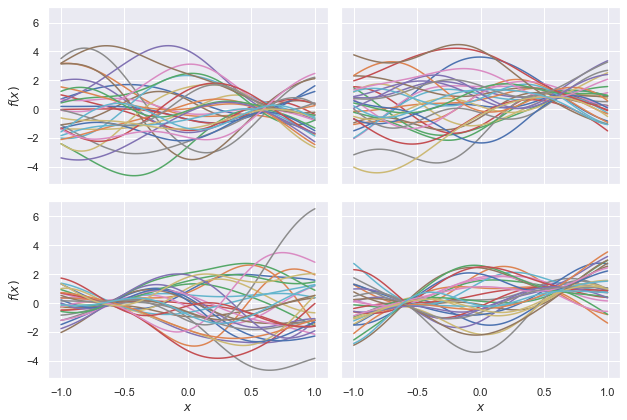

In [108]:
ngen, sig0, lam = 30, 2.0, 0.5
x = np.linspace(-1., 1., 100)
gen = np.random.RandomState(seed=123)
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(9, 6))
fx = gplearn([80], [0.], [0.3], x, sig0, lam, ngen, gen)
axes[0,0].plot(x, fx.T, '-')
axes[0,0].set_ylabel('$f(x)$')
fx = gplearn([80], [1.], [0.3], x, sig0, lam, ngen, gen)
axes[0,1].plot(x, fx.T, '-')
fx = gplearn([20], [0.], [0.1], x, sig0, lam, ngen, gen)
axes[1,0].plot(x, fx.T, '-')
axes[1,0].set_xlabel('$x$')
axes[1,0].set_ylabel('$f(x)$')
fx = gplearn([20, 80], [0., 1.], [0.1, 0.3], x, sig0, lam, ngen, gen)
axes[1,1].plot(x, fx.T, '-')
axes[1,1].set_xlabel('$x$')
plt.tight_layout()

For more information about learning with Gaussian Processes, the [definitive reference](http://www.gaussianprocess.org/gpml/) is available as a free ebook.  In many cases, the sampling approach you implemented is not necessary (but still enlightening) since the mean and covariance of the posterior at unobserved points $x_i$ can be calculated directly with some linear algebra. The [scikit-learn GP module](https://scikit-learn.org/stable/modules/gaussian_process.html) is a good starting point for practical calculations.

### Problem 2

Consider a probability density $U(x\mid x_\text{lo}, x_\text{hi})$ that is uniform on $x_\text{lo} \le x < x_\text{hi}$.

Implement the function below to evaluate the Wasserstein metric $W_1$ between $U(x\mid x_\text{lo}, x_\text{hi})$ and $U(y\mid y_\text{lo}, y_\text{hi})$ using the earlier definition:
$$
W_1(g, h) = \int_0^1\, \left| G^{-1}(z) - H^{-1}(z)\right|\, dz \; ,
$$
where $G$ and $H$ are the cumulative distribution functions corresponding to $g$ and $h$. Hint: this integral can be done analytically (but carefully consider the different cases introduced by the absolute value), so your function only needs to evaluate the result.

In [146]:
def W1_uniform(xlo, xhi, ylo, yhi):
    """Evaluate the Wasserstein distance between two uniform probability densities.
    
    Parameters
    ----------
    xlo, xhi : floats
        Range where g(x) = U(x|xlo,xhi) is non zero, with xlo < xhi.
    ylo, yhi : floats
        Range where h(y) = U(y|ylo,yhi) is non zero, with ylo < yhi.
        
    Returns
    -------
    The distance W1(g, h) calculated using an analytic result.
    """
    assert xlo < xhi and ylo < yhi
    # YOUR CODE HERE
    
    dxy = xlo - ylo
    dx = xhi - xlo
    dy = yhi - ylo    
        
    if dx - dy > 0 and dxy >= 0:
        
        summa = 0.5 * (dx - dy) + dxy
        
    elif dx - dy < 0 and dxy < 0:
        
        summa = -(0.5 * (dx - dy) + dxy)
        
    elif dx - dy > 0 and dxy < 0:
        
        zcrit = - dxy / (dx - dy)
        
        summa = - 2 * (0.5 * (zcrit ** 2) * (dx - dy) + zcrit * dxy) + (0.5 * (dx - dy) + dxy)
        
    elif dx - dy < 0 and dxy >= 0:
        
        zcrit =  - dxy / (dx - dy)
        
        summa =  2 * (0.5 * (zcrit ** 2) * (dx - dy) + zcrit * dxy) - (0.5 * (dx - dy) + dxy)
        
    elif dx - dy == 0:
        
        summa = abs(dxy)            
        
    return summa
        
        
    

In [148]:
# A correct solution should pass these tests.
assert np.allclose(W1_uniform(0., 1., 0., 1.), 0)
assert np.allclose(W1_uniform(0.5, 1., 0., 1.), 1/4)
assert np.allclose(W1_uniform(0., 1., 0., 0.5), 1/4)
assert np.allclose(W1_uniform(0., 0.5, 0.5, 1.), 1/2)
assert np.allclose(W1_uniform(0.5, 1., 0., 0.5), 1/2)
assert np.allclose(W1_uniform(0., 0.5, 1., 1.5), 1)

Next, implement the function below to calculate the KL divergence between the same two uniform distributions:
$$
\text{KL}( g \parallel h ) \equiv \int_{-\infty}^{+\infty} d x\, g(x)\, \log\frac{g(x)}{h(x)}
$$
As above, you can evaluate this integral analytically, so your function only needs to return the result.

In [149]:
def KL_uniform(xlo, xhi, ylo, yhi):
    """Evaluate the Kulback-Leibler distance between two uniform probability densities.
    
    Parameters
    ----------
    xlo, xhi : floats
        Range where g(x) = U(x|xlo,xhi) is non zero, with xlo < xhi.
    ylo, yhi : floats
        Range where h(y) = U(y|ylo,yhi) is non zero, with ylo < yhi.
        
    Returns
    -------
    The distance KL(g || h) calculated using an analytic result.
    """
    assert xlo < xhi and ylo < yhi
    # YOUR CODE HERE
    
    dx = xhi - xlo
    dy = yhi - ylo
    
    if xlo < ylo or xhi >  yhi:
        return np.inf
    
    elif xlo >= ylo and xhi <= yhi:
        KL = np.log(yhi - ylo) - np.log(xhi - xlo)
        return KL
    

In [150]:
# A correct solution should pass these tests.
assert np.allclose(KL_uniform(0., 1., 0., 1.), 0)
assert np.allclose(KL_uniform(0., 0.5, 0., 1.), np.log(2))
assert np.allclose(KL_uniform(0., 1., 0., 0.5), np.inf)
assert np.allclose(KL_uniform(0., 0.5, 0.5, 1.), np.inf)
assert np.allclose(KL_uniform(0.5, 1., 0., 0.5), np.inf)
assert np.allclose(KL_uniform(0., 0.5, 1., 1.5), np.inf)

Notice how the KL divergence gives the same (infinite) result whenever $h(x) = 0$ is zero somewhere that $g(x) \ne 0$, so does not provide any useful measure of "closeness" in these cases. Contrast this with the earth-mover distance $W_1$ which (roughly) measures how much $g(x)$ would need to be translated to look more like $h(x)$.

The plot below fixes the light gray filled distribution and shows the values of W1 and KL relative to a sliding (un-filled) distribution to illustrate this point:

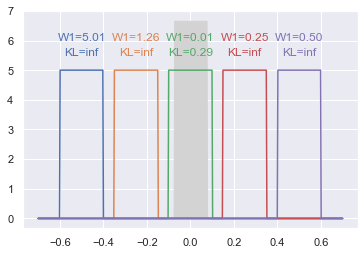

In [151]:
x = np.linspace(-0.7, 0.7, 500)
xlo, xhi = -0.075, 0.075
g = scipy.stats.uniform(xlo, xhi - xlo)
plt.fill_between(x, g.pdf(x), color='lightgray')
for ylo in [-0.6, -0.35, -0.1, 0.15, 0.4]:
    yhi = ylo + 0.2
    h = scipy.stats.uniform(ylo, yhi - ylo)
    L = plt.plot(x, h.pdf(x))
    c = L[-1].get_color()
    W1 = W1_uniform(xlo, xhi, ylo, yhi)
    KL = KL_uniform(xlo, xhi, ylo, yhi)
    plt.text(0.5 * (ylo + yhi), 6.0, f'W1={W1:.2f}', color=c, horizontalalignment='center')
    plt.text(0.5 * (ylo + yhi), 5.5, f'KL={KL:.2f}', color=c, horizontalalignment='center')